In [6]:
!pip install scikit-learn
!pip install imblearn
!pip install torch
!pip install torch-geometric
!pip install matplotlib seaborn

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torch_geometric.data import Data as GeometricData
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem
from rdkit.Chem import AllChem

np.random.seed(42)
torch.manual_seed(42)

LOAD AND PREPROCESS THE DATASET

In [8]:
data = pd.read_csv('total.csv')

smiles_list = data['name'].values

if len(data) < 142:
    raise ValueError("The dataset should contain exactly 142 ligands.")
data['target'] = [1] * 30 + [0]*(len(data)-30)

print(data)

data_ml = data.drop(['name'], axis=1)

data_ml = data_ml.dropna(axis=1, how='any')

X_ml = data_ml.drop('target', axis=1)
y_ml = data_ml['target']

print(f"Original number of features: {X_ml.shape[1]}")
print(f"Number of samples: {X_ml.shape[0]}")

                                                  name        ABC      ABCGG  \
0                                C(CC(=O)O)C(=O)C(=O)O   6.870470   7.091508   
1                                       C(C(C(=O)O)O)O   4.530370   5.004088   
2                                           C(C(=O)O)N   3.047207   3.305183   
3    COC1=C(C=CC(=C1)OC)NC(C1=C(C=CC=C1)NS(=O)(=O)C...  21.457501  18.077077   
4    ClC1=C(C=C(C=C1)S(=O)(=O)NC1=CC=C(C=C1)N1N=NC=...  22.758093  18.616094   
..                                                 ...        ...        ...   
137              C1C[C@H](Cc2c1[nH+]c(nc2N)N)C(=O)[O-]  11.629947   9.996914   
138                c1ccc(cc1)/N=C(/N/N=C\c2ccco2)\[S-]  12.837312  10.925184   
139    C[C@]1(CC[C@@H](C1(C)C)C(=O)NC2CCCCC2)C(=O)[O-]  15.395774  14.129971   
140                c1cc(nc(c1)Nc2cc(ccc2F)Cl)C(=O)[O-]  13.791708  11.653835   
141         Cc1c(c([nH]n1)c2ccc(cc2)C(C)(C)C)C(=O)[O-]  14.723691  13.175009   

     nAcid  nBase    SpAbs_A   SpMax_A 

FEATURE SELECTION PROCESS

This feature selection process reduces the number of features from the original set to a more manageable and meaningful subset, 
helping to avoid overfitting and speeding up the training of models. 

In [9]:
variance_threshold = 0.1 
selector_variance = VarianceThreshold(threshold=variance_threshold)
X_variance = selector_variance.fit_transform(X_ml)

mask_variance = selector_variance.get_support()
features_variance = X_ml.columns[mask_variance]

print(f"Number of features after VarianceThreshold: {X_variance.shape[1]}")

k_best = 30 
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
X_kbest = selector_kbest.fit_transform(X_variance, y_ml)

mask_kbest = selector_kbest.get_support()
features_kbest = features_variance[mask_kbest]

print(f"Number of features after SelectKBest: {X_kbest.shape[1]}")

selected_features = features_kbest.tolist()

print(f"Selected Features: {selected_features}")

X_selected = X_ml[selected_features]

print(f"Shape of X_selected: {X_selected.shape}")

Number of features after VarianceThreshold: 539
Number of features after SelectKBest: 30
Selected Features: ['ATSC3dv', 'ATSC4dv', 'ATSC3d', 'ATSC4d', 'ATSC4Z', 'ATSC4m', 'ATSC1v', 'ATSC4v', 'ATSC8v', 'ATSC4p', 'AATSC3dv', 'GATS1c', 'C4SP3', 'Xpc-6dv', 'Xp-6dv', 'Xp-7dv', 'NsOH', 'SsOH', 'fragCpx', 'MIC0', 'MIC1', 'SlogP_VSA11', 'EState_VSA8', 'MPC7', 'MPC8', 'MPC9', 'MPC10', 'TMPC10', 'n6Ring', 'naHRing']
Shape of X_selected: (142, 30)


In [10]:
from collections import Counter
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_selected, y_ml, test_size=0.2, stratify=y_ml, random_state=42)

print("Training set class distribution:", Counter(y_train_ml))
print("Testing set class distribution:", Counter(y_test_ml))

Training set class distribution: Counter({0: 89, 1: 24})
Testing set class distribution: Counter({0: 23, 1: 6})


In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ml, y_train_ml)

smote = SMOTE(random_state=42)
X_test_ml, y_test_ml = smote.fit_resample(X_test_ml, y_test_ml)

print(f"After SMOTE, number of samples: {X_train_ml.shape[0]}")
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")
print(f"Class distribution after SMOTE: {Counter(y_test_ml)}")

After SMOTE, number of samples: 113
Class distribution after SMOTE: Counter({0: 89, 1: 89})
Class distribution after SMOTE: Counter({1: 23, 0: 23})


In [12]:
scaler_ml = StandardScaler()
X_train_ml_scaled = scaler_ml.fit_transform(X_train_ml)
X_test_ml_scaled = scaler_ml.transform(X_test_ml)

In [13]:
models_ml = {
    'Support Vector Machine': SVC( 
        kernel='rbf',           
        C=1.0,                      
        class_weight='balanced',    
        random_state=42,
        probability=True),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(30, 20),   
        alpha=0.0001,  
        max_iter=500,  
        random_state=42,
    )
}

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name, normalize=False):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - model_name (str): Name of the model (for the plot title).
    - normalize (bool): Whether to normalize the confusion matrix.

    Returns:
    - None
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = f'Normalized Confusion Matrix for {model_name}'
    else:
        fmt = 'd'
        title = f'Confusion Matrix for {model_name}'

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=False,
                xticklabels=['Non-Agonist', 'Agonist'],
                yticklabels=['Non-Agonist', 'Agonist'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()


Support Vector Machine - Accuracy: 0.904 ± 0.043
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.86      0.83      0.84        23

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46

ROC AUC Score: 0.947



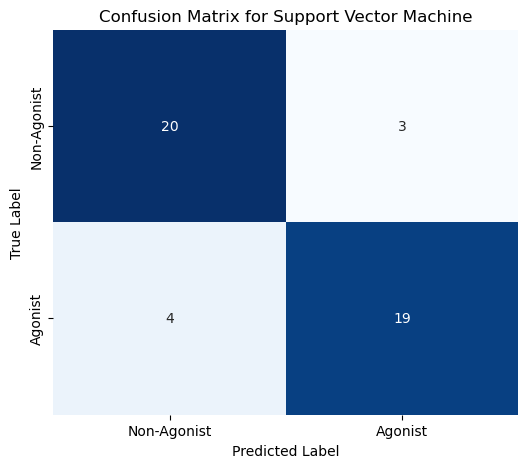

Naive Bayes - Accuracy: 0.776 ± 0.110
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        23
           1       1.00      0.70      0.82        23

    accuracy                           0.85        46
   macro avg       0.88      0.85      0.84        46
weighted avg       0.88      0.85      0.84        46

ROC AUC Score: 0.856



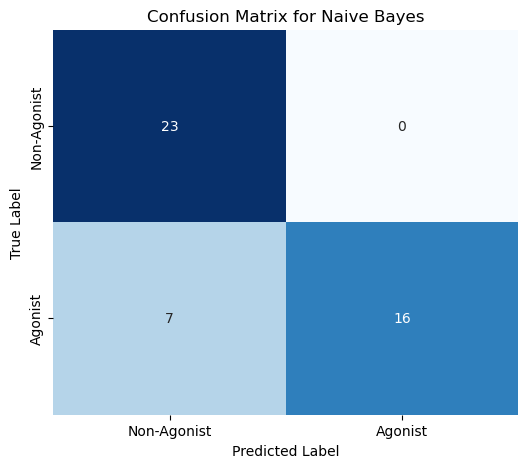

K-Nearest Neighbors - Accuracy: 0.842 ± 0.071
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.80      0.87      0.83        23

    accuracy                           0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46

ROC AUC Score: 0.917



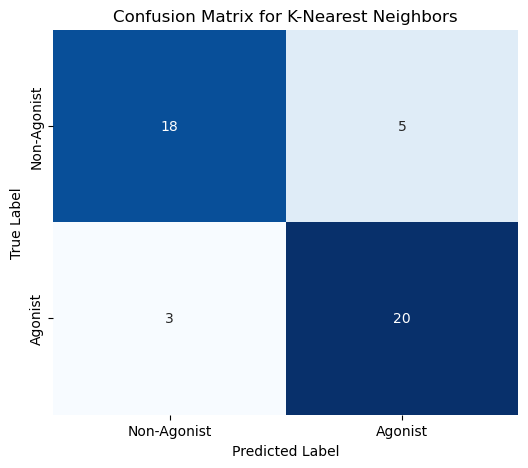

Gradient Boosting - Accuracy: 0.893 ± 0.041
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       0.84      0.91      0.88        23

    accuracy                           0.87        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.87      0.87      0.87        46

ROC AUC Score: 0.857



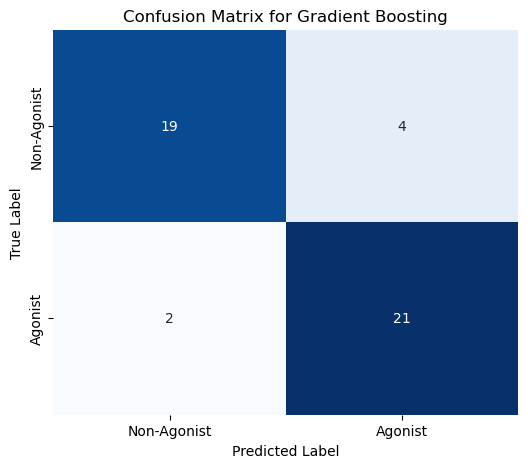

Random Forest - Accuracy: 0.927 ± 0.035
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        23
           1       0.78      0.78      0.78        23

    accuracy                           0.78        46
   macro avg       0.78      0.78      0.78        46
weighted avg       0.78      0.78      0.78        46

ROC AUC Score: 0.919



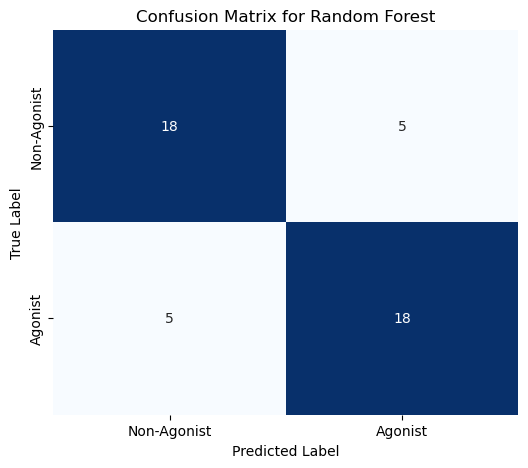

Neural Network - Accuracy: 0.927 ± 0.058
Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.95      0.78      0.86        23

    accuracy                           0.87        46
   macro avg       0.88      0.87      0.87        46
weighted avg       0.88      0.87      0.87        46

ROC AUC Score: 0.930



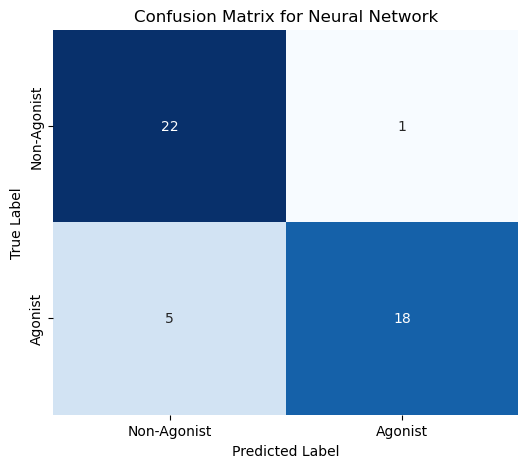

In [15]:
model_names = []
model_accuracies = []

for name, model in models_ml.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=skf, scoring='accuracy')
    print(f"{name} - Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
    
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    y_pred = pipeline.predict(X_test_ml)
    y_proba = pipeline.predict_proba(X_test_ml)[:, 1]
    
    acc = accuracy_score(y_test_ml, y_pred)
    model_names.append(name)
    model_accuracies.append(acc)
    
    print(f"Classification Report for {name}:")
    print(classification_report(y_test_ml, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test_ml, y_proba):.3f}\n")
    plot_confusion_matrix(y_test_ml, y_pred, model_name=name, normalize=False)

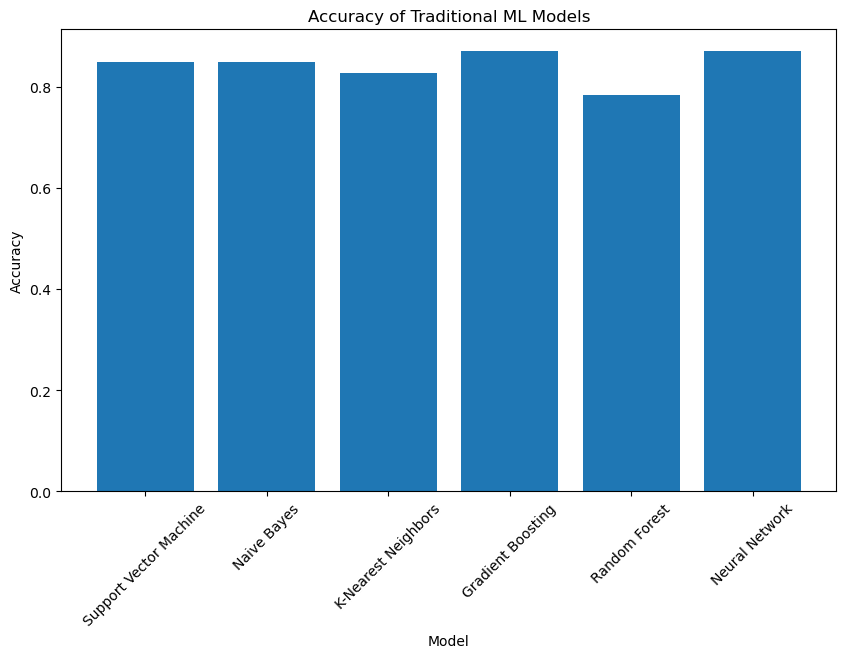

In [16]:
# Plot accuracies of traditional ML models
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Traditional ML Models')
plt.xticks(rotation=45)
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

new_data = pd.read_csv('ligandsdesc.csv')

compound_names = new_data['name']

new_data_ml = new_data.drop(['name'], axis=1)

new_data_ml = new_data_ml.dropna(axis=1, how='any')

new_X_selected = new_data_ml[selected_features]

print(f"Shape of new_X_selected: {new_X_selected.shape}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_selected)

best_model_name = 'Support Vector Machine' 
best_model = models_ml[best_model_name]

best_model.fit(X_train_scaled, y_ml)

new_X_scaled = scaler.transform(new_X_selected)

new_predictions = best_model.predict(new_X_scaled)
new_probabilities = best_model.predict_proba(new_X_scaled)[:, 1]

results = pd.DataFrame({
    'name': compound_names,
    'prediction': new_predictions,
    'probability': new_probabilities
})

results['prediction_label'] = results['prediction'].map({0: 'Non-Bioactive', 1: 'Bioactive'})

print(results[['name', 'prediction_label', 'probability']])

results[['name', 'prediction_label', 'probability']].to_csv('prediction_results.csv', index=False)


Shape of new_X_selected: (199, 30)
                                 name prediction_label  probability
0              O=C([O-])[C@H](O)C1CC1    Non-Bioactive     0.036210
1        [NH3+][C@H](C(=O)[O-])C1COC1    Non-Bioactive     0.073791
2    O=C([O-])[C@@H](O)[C@@H](O)C(F)F    Non-Bioactive     0.179453
3                   O=C([O-])C1(O)CC1        Bioactive     0.494373
4                 C[C@H](S)CC(=O)[O-]    Non-Bioactive     0.008541
..                                ...              ...          ...
194               Cc1ccc(C(=O)[O-])s1    Non-Bioactive     0.002054
195                 O=C([O-])c1cccnn1    Non-Bioactive     0.001686
196          O=C1C[C@H](C(=O)[O-])CN1        Bioactive     0.398084
197               CC(F)(F)CCC(=O)[O-]        Bioactive     0.874417
198                          CCC(=O)O        Bioactive     0.984892

[199 rows x 3 columns]
